In [1]:
!git clone https://github.com/rushikesh-katkar/transformer.git

Cloning into 'transformer'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 113 (delta 25), reused 111 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 624.43 KiB | 3.02 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:

%cd /content/transformer/src/main/python/


/content/transformer/src/main/python


In [3]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:

torch.set_printoptions(
    precision=2,     # number of decimals
    linewidth=120,   # max characters per line
    sci_mode=False   # disable scientific notation
)

loss_fn = torch.nn.CrossEntropyLoss()


In [5]:

from utils.Embeddings.Embeddings import Embeddings
from utils.Attention.Attention import attentionLayer
from utils.Attention.Attention import multiHeads
from utils.Attention.Attention import residualConnection
from utils.FFN.FFN import feedForward
from utils.Tokenizer.Tokenizer import SimpleTokenizer
from utils.LayerNorm.LayerNorm import LayerNorm



In [6]:

# Data
with open("data/Text.txt", 'r') as f:
    text = f.read()
words = text.lower().split(" ")
import re

def clean_words(word_list):
    cleaned = []
    for word in word_list:
        word_lower = word.lower()  # convert to lowercase
        if re.fullmatch(r"[a-z]+", word_lower) and (len(word_lower) >=7) and (len(word_lower) <= 7) :
            cleaned.append(word_lower)
    return cleaned

words = clean_words(words)
print("Some words from the training data")
print(words[:5])



Some words from the training data
['reddits', 'started', 'reasons', 'started', 'harvard']


In [7]:

all_words = words.copy()

new_words = []
seven_letter_count = 0
data = []

for w in words:
    if len(w) == 7:
        seven_letter_count += 1
        if seven_letter_count < 10000:
            new_words.append(w)
        else:
            data.append(w) # keep from 10000th onward
    else:
        new_words.append(w)       # keep non-7-letter words

# Replace words
words = new_words


In [8]:

import random

def prepare_training_example(word, tokenizer, max_len=8, mask_prob=0.5):

    padded_word = list(word) + ['<e>' for i in range(max_len - len(word))]

    x_chars = padded_word[::]

    for i in range(len(x_chars)):
        if x_chars[i] != '<e>' and (x_chars[i] != '<s>') and random.random() < mask_prob:
            x_chars[i] = '<mask>'

    x_encoded = tokenizer.encode(x_chars, pad=True)

    candidates = [i for i in range(len(x_chars)) if ((x_chars[i] not in ['<e>', '<s>']) & (x_chars[i] == '<mask>'))]

    y_chars = list(x_chars)

    if candidates:

        idx = random.choice(candidates)

        y_chars[idx] = padded_word[idx]

    y_encoded = tokenizer.encode(list(y_chars), pad=True)

    return x_encoded, y_encoded



In [12]:

sequence   = 'mango'

Tokenizer  = SimpleTokenizer(list('abcdefghijklmnopqrstuvwxyz'))

x          = Tokenizer.encode(sequence, pad = True)


print("Example usage of the simple encoder")

print(f"Original word: {sequence}")

print(f"Tokenized word: {x}")

print("Training example")

print(prepare_training_example(sequence, tokenizer = Tokenizer, max_len=7, mask_prob=0.5))


Example usage of the simple encoder
Original word: mangohh
Tokenized word: tensor([[ 0, 13,  1, 14,  7, 15,  8,  8, 27]], device='cuda:0')
Training example
(tensor([[ 0, 13,  1, 28, 28, 28,  8, 28, 27]], device='cuda:0'), tensor([[ 0, 13,  1, 28,  7, 28,  8, 28, 27]], device='cuda:0'))


In [13]:

import random

X, Y = [], []
x_before, y_before =  None, None

for word in words:

    mask_prob = random.uniform(0.1, 0.9)
    u = random.random()

    for _ in range(20):

        x, y = prepare_training_example(word, Tokenizer, max_len=7, mask_prob=mask_prob)

        if (x_before != None) and torch.all((x_before == x) & (y_before == y)):

            continue

        X.append(x)

        Y.append(y)

        x_before, y_before = x, y


In [14]:
idx = 330
print(f"Example word: {words[idx]}\n")

print(f"Input sequence:  {X[idx].squeeze()}")
print(f"Decoded Input sequence:  {"".join(Tokenizer.itos[i] for i in X[idx].to("cpu").squeeze().numpy())}\n")


print(f"Target sequence:  {Y[idx].squeeze()}")
print(f"Decoded Target sequence:  {"".join(Tokenizer.itos[i] for i in Y[idx].to("cpu").squeeze().numpy())}")



Example word: because

Input sequence:  tensor([ 0, 19,  8, 28, 18, 28, 28, 28, 27], device='cuda:0')
Decoded Input sequence:  <s>sh<mask>r<mask><mask><mask><e>

Target sequence:  tensor([ 0, 19,  8, 28, 18, 28, 14, 28, 27], device='cuda:0')
Decoded Target sequence:  <s>sh<mask>r<mask>n<mask><e>


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:

# Model
# --- prepared training examples ---
# X: list of tensors (B, T)
# Y: list of tensors (B, T)
# Convert to tensors
X_tensor = torch.stack(X).to(device)  # shape: (B, T)
Y_tensor = torch.stack(Y).to(device)  # shape: (B, T)
X_tensor.shape, Y_tensor.shape


(torch.Size([194744, 1, 9]), torch.Size([194744, 1, 9]))

In [17]:
X_tensor[:2], Y_tensor[:2]

(tensor([[[ 0, 28,  5, 28, 28, 28, 28, 28, 27]],
 
         [[ 0, 18,  5, 28,  4, 28, 28, 28, 27]]], device='cuda:0'),
 tensor([[[ 0, 28,  5, 28, 28, 28, 20, 28, 27]],
 
         [[ 0, 18,  5,  4,  4, 28, 28, 28, 27]]], device='cuda:0'))

In [18]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, clear_output



In [19]:

# --- Hyperparameters ---
seq_len    = 9 ## max word lenght = 7 + 2 tokens (start and end)
vocab_size = 29 ## 26 alphabets + (start, end and mask)
d_model    = 32
num_epochs = 10000
learning_rate = 0.0002


emb        = Embeddings(vocab_size = vocab_size, d_model= d_model, max_len= seq_len)

multiHeadLayer1 = multiHeads(num_heads = 4,
                            d_model   = d_model,
                            max_len   = seq_len)

multiHeadLayer2 = multiHeads(num_heads = 4,
                            d_model   = d_model,
                            max_len   = seq_len)

multiHeadLayer3 = multiHeads(num_heads = 4,
                            d_model   = d_model,
                            max_len   = seq_len)


rc1 = residualConnection()

rc2 = residualConnection()

rc3 = residualConnection()

FFN = feedForward(d_model = d_model, max_len = seq_len, vocab_size = vocab_size)

L1  = LayerNorm(d_model, seq_len)

# --- Loss and optimizer ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(emb.parameters() +
                       multiHeadLayer1.parameters() +
                       multiHeadLayer2.parameters() +
                       multiHeadLayer3.parameters() +

                       FFN.parameters() + L1.parameters(),
                       lr=learning_rate)




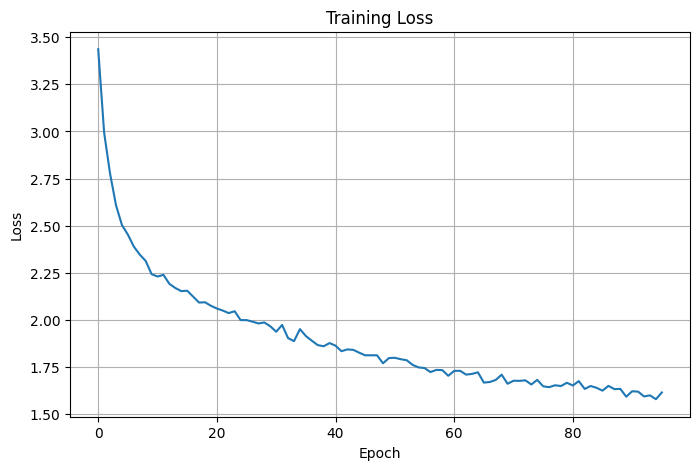

final training loss: 1.6161537170410156


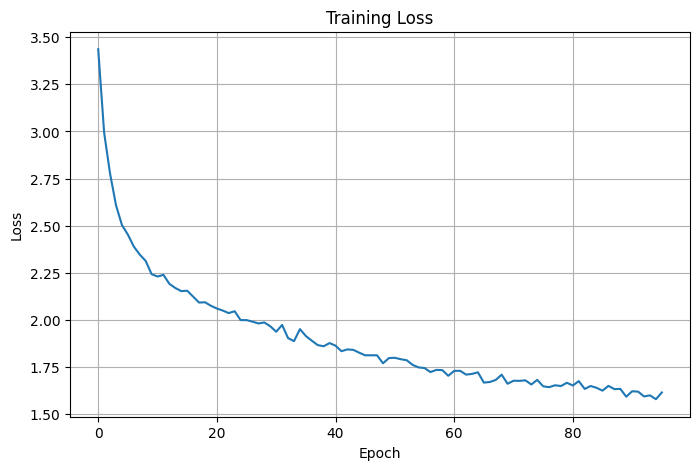

In [33]:

# --- Training loop ---

fig, ax = plt.subplots(figsize=(8,5))
display(fig)

# loss_history = []
learning_rate = 0.005


for epoch in range(num_epochs):
    optimizer.zero_grad()

    idx  = random.sample(range(len(words)), 5000)

    X_idx = X_tensor[idx].squeeze(1)
    Y_idx = Y_tensor[idx].squeeze(1)


    # Forward pass
    x0 = emb(X_idx)
    x1 = multiHeadLayer1(x0)
    x2 = rc1(x0, x1)

    x3 = multiHeadLayer2(x2)
    x4 = rc2(x2, x3)

    x5 = multiHeadLayer3(x4)
    x6 = rc3(x4, x5)

    x11 = L1(x6)
    logits = FFN(x11)

    targets = Y_idx
    ## Loss on all tokens -------- OPTION A



    # # Compute loss
    # loss = loss_fn(
    #     logits.view(-1, logits.size(-1)),  # (B*T, V)
    #     targets.view(-1)                    # (B*T)
    # )

    ## Loss on just revealed mask ------ OPTION B

    mask = (X_idx == 28) & (Y_idx <= 26) & (Y_idx > 0)

    mask_flat = mask.view(-1)

    masked_logits = logits.view(-1, logits.size(-1))[mask_flat]

    masked_targets = targets.view(-1)[mask_flat]

    loss = loss_fn(masked_logits, masked_targets)

    # Backward pass
    loss.backward()
    optimizer.step()


    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if loss.item() < 4:
            loss_history.append(loss.item())

            ax.clear()
            ax.plot(loss_history)
            ax.set_title("Training Loss")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.grid(True)

            clear_output(wait=True)
            display(fig)


print(f"final training loss: {loss_history[-1]}")



In [23]:

# Performance
def build_input_sequence(secret_word, correct):
    """
    correct: list of correctly guessed characters
    """
    seq = [0]
    for ch in secret_word:

        if ch in correct:
            seq.append(Tokenizer.stoi[ch])

        else:
            seq.append(28)  # mask

    seq.append(27)
    return torch.tensor(seq, dtype=torch.long)



In [24]:
import torch.nn.functional as F

def get_letter_from_model(secret_word, missed, correct,
                          emb, multiHeadLayer1, multiHeadLayer2, multiHeadLayer3, rc1,rc2,rc3, L1, FFN):


    x_single = build_input_sequence(secret_word, correct).to(device)
    x = x_single.unsqueeze(0)  # (1, seq_len)


    with torch.no_grad():

        x0 = emb(x)
        x1 = multiHeadLayer1(x0)
        x2 = rc1(x0, x1)

        x3 = multiHeadLayer2(x2)
        x4 = rc2(x2, x3)

        x5 = multiHeadLayer3(x4)
        x6 = rc3(x4, x5)

        # x7 = multiHeadLayer4(x6)
        # x8 = rc(x6, x7)

        # x9 = multiHeadLayer5(x8)
        # x10 = rc(x8, x9)

        x11 = L1(x6)
        logits = FFN(x11)

    mask_positions = (x_single == 28)

    letter_logits = torch.zeros(logits.size(-1)).to(device)

    for i in torch.where(mask_positions)[0]:
        letter_logits += logits[0, i]

    probs = F.softmax(letter_logits, dim=0)

    # Avoid guessing already tried letters
    tried = set(missed + correct)
    for ch in tried:
        probs[Tokenizer.stoi[ch]] = 0.0

    total_prob = probs.sum()

    if total_prob <= 0:

      raise ValueError(f"All probabilities are zero {total_prob}")


    if total_prob <= 0:
        return random.choice(list(Tokenizer.stoi.keys()))

    probs = probs / total_prob

    guess_id = torch.multinomial(probs, 1).item()

    return Tokenizer.itos[guess_id]



In [27]:

def simulate_hangman_games_model(data,
                                 emb, multiHeadLayer1, multiHeadLayer2, multiHeadLayer3, rc1, rc2, rc3, L1, FFN,
                                 max_misses=6):
    wins = 0
    total = len(data)

    for secret_word in data:
        missed, correct = [], []
        game_over = False

        while not game_over:
            guess = get_letter_from_model(
                secret_word, missed, correct,
                emb, multiHeadLayer1, multiHeadLayer2, multiHeadLayer3, rc1,rc2, rc3, L1, FFN
            )

            if guess in secret_word:
                correct.append(guess)
                if all(c in correct for c in secret_word):
                    wins += 1
                    game_over = True
            else:
                missed.append(guess)
                if len(missed) >= max_misses:
                    game_over = True

    return wins, total


len(data)

3172

In [34]:

wins, total = simulate_hangman_games_model( data, emb, multiHeadLayer1, multiHeadLayer2, multiHeadLayer3, rc1,rc2, rc3, L1, FFN)

print(f"Wins: {wins}, Total: {total}")
print(f"Win rate: {wins / total:.2%}")


Wins: 1033, Total: 3172
Win rate: 32.57%
